In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('weather/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import re
import missingno as mso
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from collections import Counter
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [3]:
df= pd.read_csv(r"C:\Users\91827\OneDrive\Pictures\MCA_Notes\Python Scripts\weather_data2.csv", encoding ="utf-8")
df

,id,city_name,city_id,latitude,longitude,dt_txt,time,temp,temp_max,pressure,sea_level,grnd_level,humidity,main,description,clouds,wind_speed,wind_degree,region,state
0,103348,Amarawati,1263594,16.00,76.96,1/29/2020,08:30:00+05:30,23.45,23.45,1016,1016,971,59,Clouds,scattered clouds,44,2.83,312,West\n,Maharashtra
1,103354,Amarawati,1263594,16.00,76.96,1/30/2020,02:30:00+05:30,22.76,22.76,1012,1012,968,50,Clear,clear sky,0,1.85,162,West\n,Maharashtra
2,103362,Amarawati,1263594,16.00,76.96,1/31/2020,02:30:00+05:30,22.15,22.15,1011,1011,966,30,Clear,clear sky,0,3.05,285,West\n,Maharashtra
3,103370,Amarawati,1263594,16.00,76.96,2/1/2020,02:30:00+05:30,22.37,22.37,1009,1009,965,35,Clear,clear sky,0,2.51,192,West\n,Maharashtra
4,182345,Hardoi,1270370,27.42,80.12,2/2/2020,05:30:00+05:30,8.99,8.99,1015,1015,1001,74,Clear,clear sky,0,3.74,325,North\n,Uttar Pradesh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6085,1152195,Hoshiarpur,1269937,31.53,75.92,4/15/2020,14:30:00+05:30,35.76,35.76,1008,1008,974,14,Rain,light rain,100,1.27,94,North\n,Punjab
6086,1152314,kapurthala,1267911,31.38,75.38,4/15/2020,11:30:00+05:30,37.33,37.33,1008,1008,983,10,Rain,light rain,79,3.64,105,North\n,Punjab
6087,1152468,Gonda,1270996,27.13,81.93,4/14/2020,17:30:00+05:30,41.54,41.54,1000,1000,988,7,Clear,clear sky,3,5.91,298,North\n,Uttar Pradesh
6088,1152513,Bhatinda,1276070,30.20,74.95,4/15/2020,08:30:00+05:30,31.68,31.68,1005,1005,982,16,Clouds,scattered clouds,30,1.24,118,North\n,Punjab


In [4]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 13
Discrete feature Count 0
Continuous feature Count 13
Categorical feature Count 7


In [5]:
df.isnull().sum()*100/len(df)

id             0.0
city_name      0.0
city_id        0.0
latitude       0.0
longitude      0.0
dt_txt         0.0
time           0.0
temp           0.0
temp_max       0.0
pressure       0.0
sea_level      0.0
grnd_level     0.0
humidity       0.0
main           0.0
description    0.0
clouds         0.0
wind_speed     0.0
wind_degree    0.0
region         0.0
state          0.0
dtype: float64

In [6]:
print(numerical_feature)

['id', 'city_id', 'latitude', 'longitude', 'temp', 'temp_max', 'pressure', 'sea_level', 'grnd_level', 'humidity', 'clouds', 'wind_speed', 'wind_degree']


In [7]:
df=df.drop(["city_id","grnd_level","longitude","wind_degree","region"],axis=1)

In [8]:
df.describe()

,id,latitude,temp,temp_max,pressure,sea_level,humidity,clouds,wind_speed
count,6.090000e+03,6090.000000,6090.000000,6090.000000,6090.000000,6090.000000,6090.000000,6090.000000,6090.000000
mean,6.036779e+05,24.575319,20.567800,20.572580,1012.198030,1012.198030,50.118719,35.976847,2.758608
std,3.222256e+05,7.603464,8.691882,8.692689,4.932908,4.932908,23.355272,37.346957,1.652234
min,1.033480e+05,-8.590000,-11.170000,-11.170000,992.000000,992.000000,4.000000,0.000000,0.040000
25%,3.007098e+05,21.020000,14.970000,14.970000,1009.000000,1009.000000,31.000000,0.000000,1.550000
50%,5.999710e+05,25.900000,21.100000,21.110000,1012.000000,1012.000000,50.000000,22.000000,2.470000
75%,8.889010e+05,29.330000,26.510000,26.510000,1015.000000,1015.000000,69.000000,69.000000,3.590000
max,1.152714e+06,51.530000,44.090000,44.090000,1035.000000,1035.000000,99.000000,100.000000,13.770000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6090 entries, 0 to 6089
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6090 non-null   int64  
 1   city_name    6090 non-null   object 
 2   latitude     6090 non-null   float64
 3   dt_txt       6090 non-null   object 
 4   time         6090 non-null   object 
 5   temp         6090 non-null   float64
 6   temp_max     6090 non-null   float64
 7   pressure     6090 non-null   int64  
 8   sea_level    6090 non-null   int64  
 9   humidity     6090 non-null   int64  
 10  main         6090 non-null   object 
 11  description  6090 non-null   object 
 12  clouds       6090 non-null   int64  
 13  wind_speed   6090 non-null   float64
 14  state        6090 non-null   object 
dtypes: float64(4), int64(5), object(6)
memory usage: 713.8+ KB


In [10]:
df.duplicated().sum()

0

In [11]:
df[["temp","pressure","description","humidity","wind_speed"]].describe()

,temp,pressure,humidity,wind_speed
count,6090.000000,6090.000000,6090.000000,6090.000000
mean,20.567800,1012.198030,50.118719,2.758608
std,8.691882,4.932908,23.355272,1.652234
min,-11.170000,992.000000,4.000000,0.040000
25%,14.970000,1009.000000,31.000000,1.550000
50%,21.100000,1012.000000,50.000000,2.470000
75%,26.510000,1015.000000,69.000000,3.590000
max,44.090000,1035.000000,99.000000,13.770000


In [12]:
df[df['temp']==min(df.temp)]

,id,city_name,latitude,dt_txt,time,temp,temp_max,pressure,sea_level,humidity,main,description,clouds,wind_speed,state
604,157248,Anantnag,33.73,2/3/2020,02:30:00+05:30,-11.17,-11.17,1026,1026,65,Clear,clear sky,0,3.82,Jammu and Kashmir


In [13]:
df[df['temp']==max(df.temp)]

,id,city_name,latitude,dt_txt,time,temp,temp_max,pressure,sea_level,humidity,main,description,clouds,wind_speed,state
5762,1100115,Varanasi,25.33,4/12/2020,14:30:00+05:30,44.09,44.09,1003,1003,6,Clear,clear sky,0,5.65,Uttar Pradesh


<Axes: xlabel='temp', ylabel='Count'>

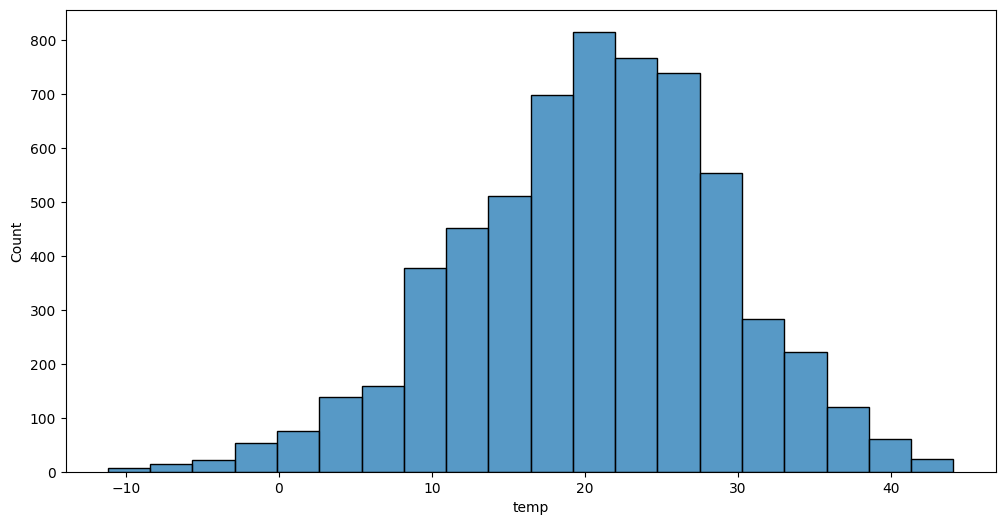

In [14]:
plt.figure(figsize=(12,6))
sns.histplot(data=df,x=df.temp,bins=20)

In [15]:
df.loc[:,['dt_txt','temp']]
df['dt_txt'] = pd.to_datetime(df['dt_txt'])

<Axes: xlabel='description', ylabel='count'>

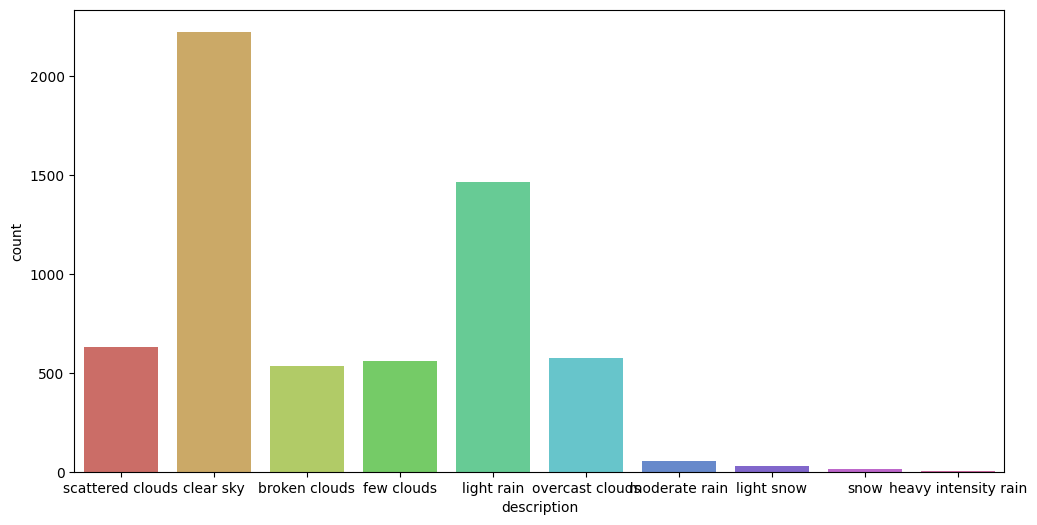

In [16]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,6))
sns.countplot( data=df, x=df.description,palette="hls")

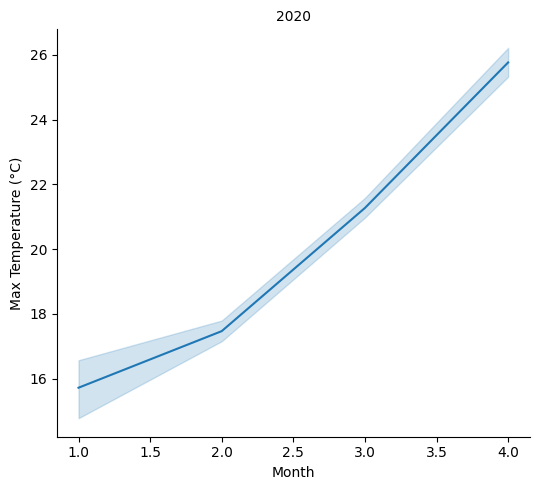

In [17]:
df['year'] = df['dt_txt'].dt.year
df['month'] = df['dt_txt'].dt.month
g = sns.FacetGrid(df, col='year', col_wrap=5, height=5)
g.map(sns.lineplot, 'month', 'temp')
g.set_axis_labels('Month', 'Max Temperature (°C)')
g.set_titles(col_template="{col_name}")
plt.show()

In [18]:
countheavyrain=len(df[df.description=="heavy intensity rain"])
countclearsky=len(df[df.description=="clear sky"])
countlightrain=len(df[df.description=="light rain"])
countlightsnow=len(df[df.description=="light snow"])
countheavysnow=len(df[df.description=="heavy snow"])
print("Percent of Heavy Rain:{:2f}%".format((countheavyrain/(len(df.description))*100)))
print("Percent of Clear Sky:{:2f}%".format((countclearsky/(len(df.description))*100)))
print("Percent of Light Rain:{:2f}%".format((countlightrain/(len(df.description))*100)))
print("Percent of Light Snow:{:2f}%".format((countlightsnow/(len(df.description))*100)))
print("Percent of Heavy Snow:{:2f}%".format((countheavysnow/(len(df.description))*100)))

Percent of Heavy Rain:0.049261%
Percent of Clear Sky:36.551724%
Percent of Light Rain:24.055829%
Percent of Light Snow:0.476190%
Percent of Heavy Snow:0.000000%


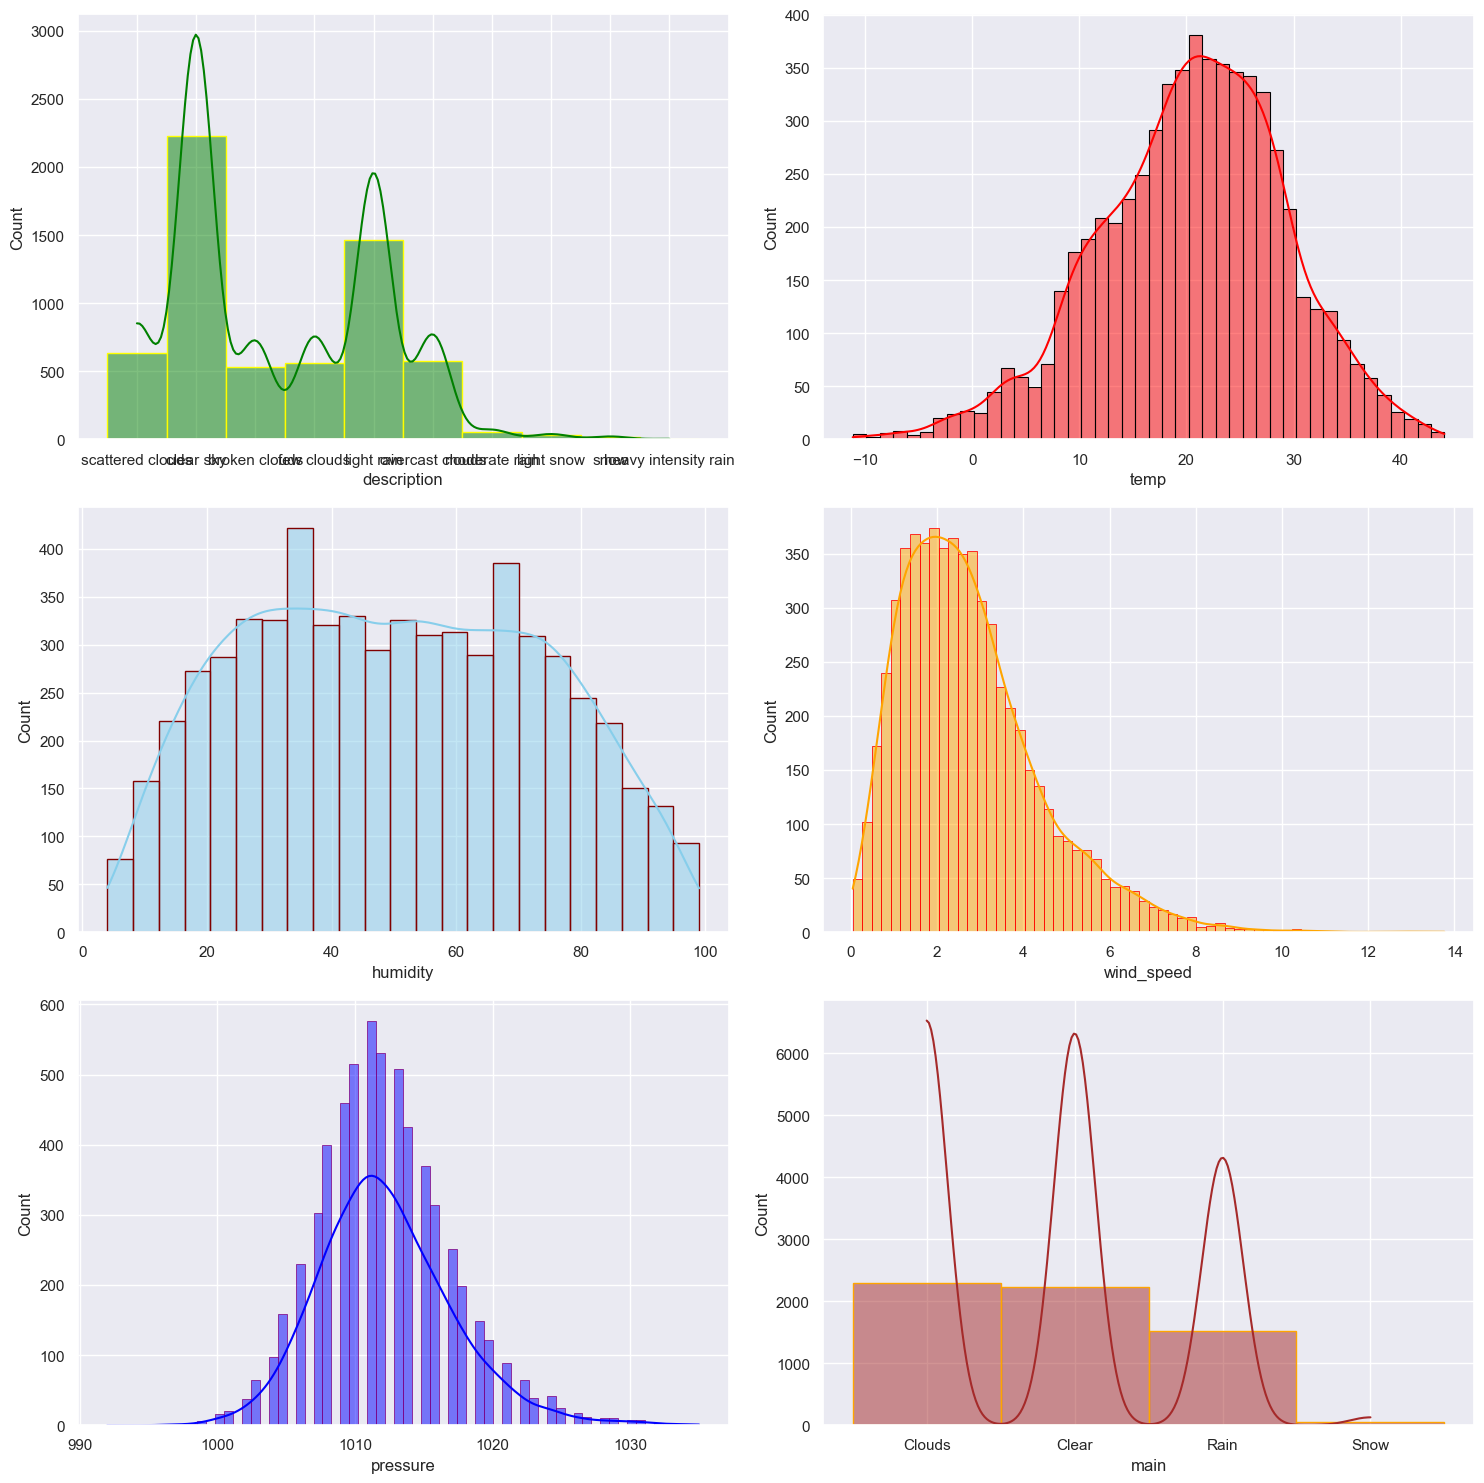

In [19]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
sns.histplot(data=df, x="description", kde=True, ax=axs[0, 0], color='green',edgecolor='yellow')
sns.histplot(data=df, x="temp", kde=True, ax=axs[0, 1], color='red',edgecolor='black')
sns.histplot(data=df, x="humidity", kde=True, ax=axs[1, 0], color='skyblue',edgecolor='maroon')
sns.histplot(data=df, x="wind_speed", kde=True, ax=axs[1, 1], color='orange',edgecolor='red')
sns.histplot(data=df, x="pressure", kde=True, ax=axs[2, 0], color='blue',edgecolor='purple')
sns.histplot(data=df, x="main", kde=True, ax=axs[2, 1], color='brown',edgecolor='orange')

plt.tight_layout()
plt.show()

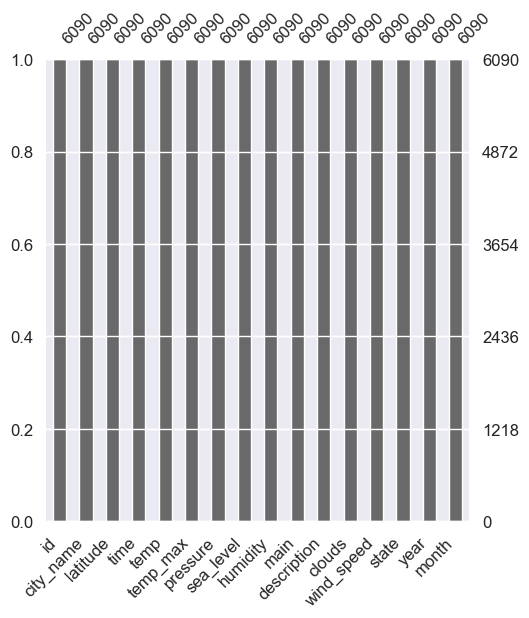

In [20]:
plt.figure(figsize=(12,6))
axz=plt.subplot(1,2,2)
mso.bar(df.drop(["dt_txt"],axis=1),ax=axz,fontsize=12);

<Axes: xlabel='main'>

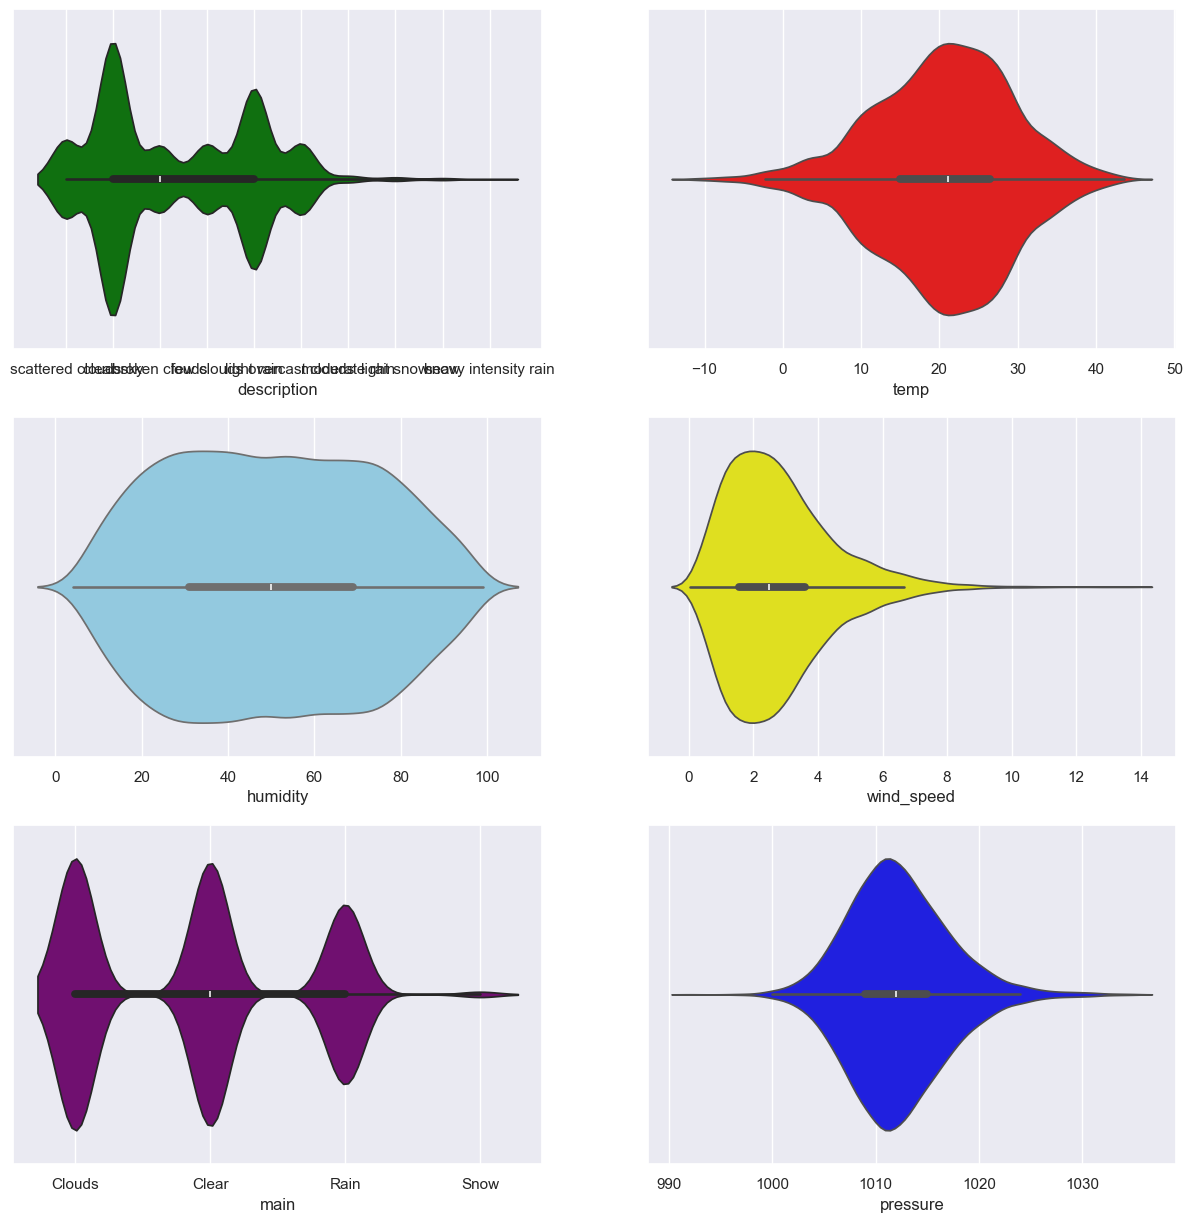

In [21]:
sns.set(style="darkgrid")
fig,axs=plt.subplots(3,2,figsize=(15,15))
sns.violinplot(data=df,x="description",ax=axs[0,0],color='green')
sns.violinplot(data=df,x="temp",ax=axs[0,1],color='red')
sns.violinplot(data=df,x="humidity",ax=axs[1,0],color='skyblue')
sns.violinplot(data=df,x="wind_speed",ax=axs[1,1],color='yellow')
sns.violinplot(data=df,x="pressure",ax=axs[2,1],color='blue')
sns.violinplot(data=df,x="main",ax=axs[2,0],color='purple')

<Axes: xlabel='main', ylabel='description'>

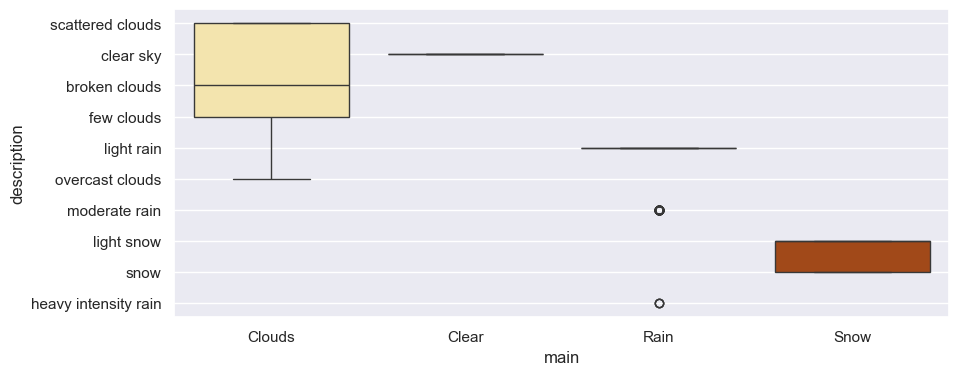

In [22]:
plt.figure(figsize=(10,4))
sns.boxplot(x="main",y="description",data=df,palette="YlOrBr")

<Axes: xlabel='temp', ylabel='description'>

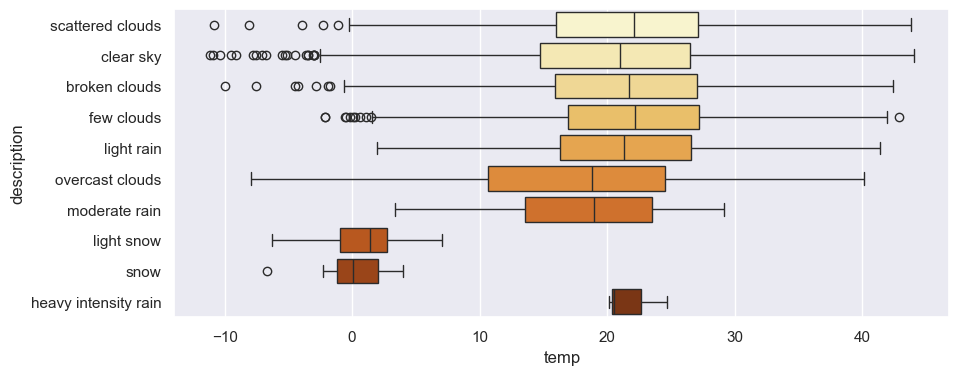

In [23]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df, x="temp",y="description",palette="YlOrBr")

<Axes: xlabel='wind_speed', ylabel='description'>

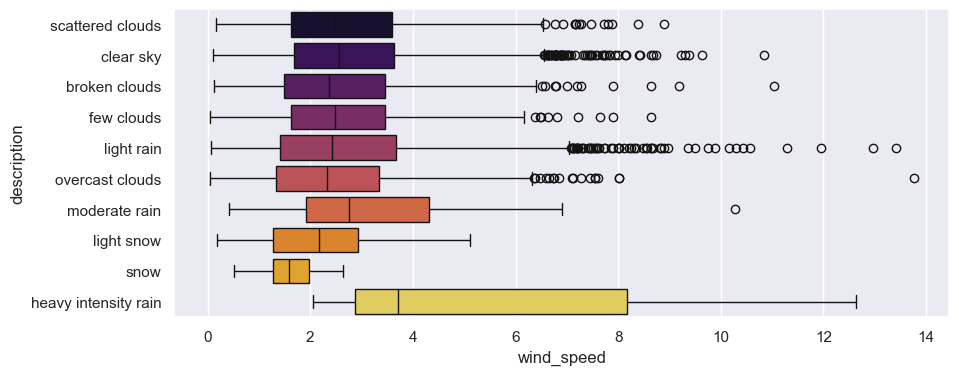

In [24]:
plt.figure(figsize=(10,4))
sns.boxplot(x="wind_speed",y="description",data=df,palette="inferno")

<Axes: xlabel='humidity', ylabel='description'>

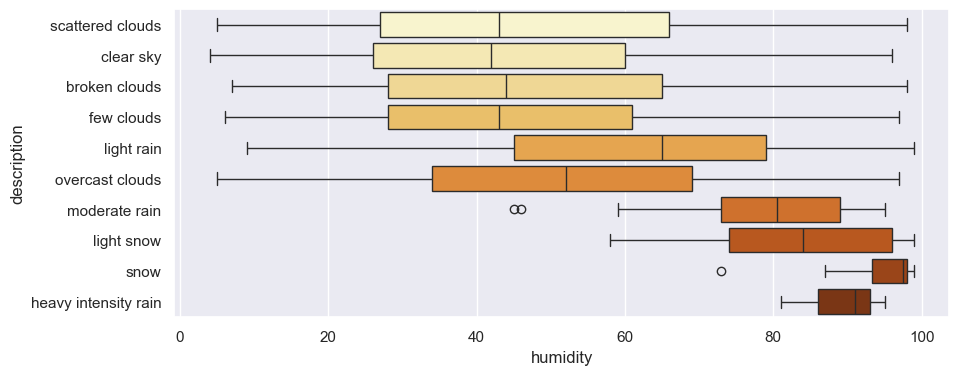

In [25]:
plt.figure(figsize=(10,4))
sns.boxplot(x="humidity",y="description",data=df,palette="YlOrBr")

<Axes: xlabel='temp', ylabel='description'>

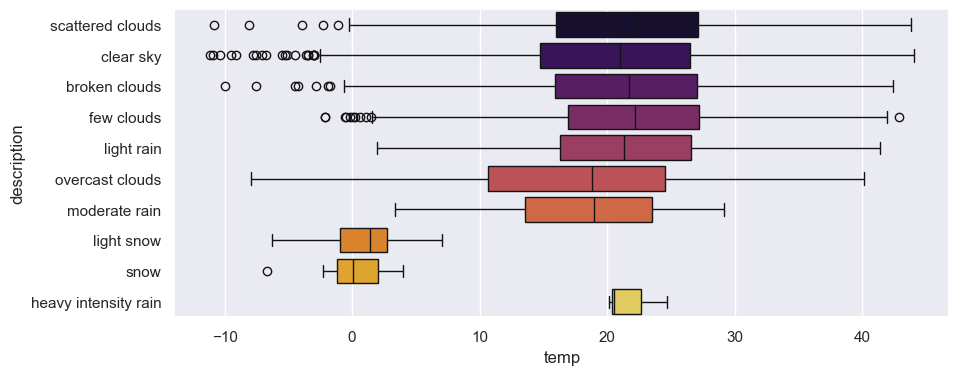

In [26]:
plt.figure(figsize=(10,4))
sns.boxplot(x="temp",y="description",data=df,palette="inferno")

<Axes: xlabel='pressure', ylabel='description'>

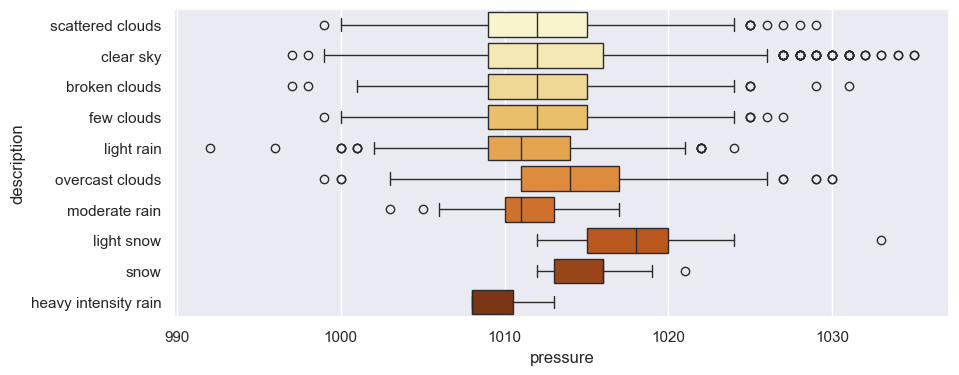

In [27]:
plt.figure(figsize=(10,4))
sns.boxplot(x="pressure",y="description",data=df,palette="YlOrBr")

In [28]:
df=df.drop(["id","temp_max","city_name","state","year","month","sea_level"],axis=1)

In [29]:
df=df.drop(["latitude","main","time"],axis =1)

In [30]:
df.head()

,dt_txt,temp,pressure,humidity,description,clouds,wind_speed
0,2020-01-29,23.45,1016,59,scattered clouds,44,2.83
1,2020-01-30,22.76,1012,50,clear sky,0,1.85
2,2020-01-31,22.15,1011,30,clear sky,0,3.05
3,2020-02-01,22.37,1009,35,clear sky,0,2.51
4,2020-02-02,8.99,1015,74,clear sky,0,3.74


In [31]:
df= df.drop(['dt_txt'], axis=1)

In [32]:
lc=LabelEncoder()
df["description"]=lc.fit_transform(df["description"])

In [33]:
x=((df.loc[:,df.columns!="description"]).astype('int64')).values[:,0:]
y=df["description"].values

In [34]:
df.head()

,temp,pressure,humidity,description,clouds,wind_speed
0,23.45,1016,59,8,44,2.83
1,22.76,1012,50,1,0,1.85
2,22.15,1011,30,1,0,3.05
3,22.37,1009,35,1,0,2.51
4,8.99,1015,74,1,0,3.74


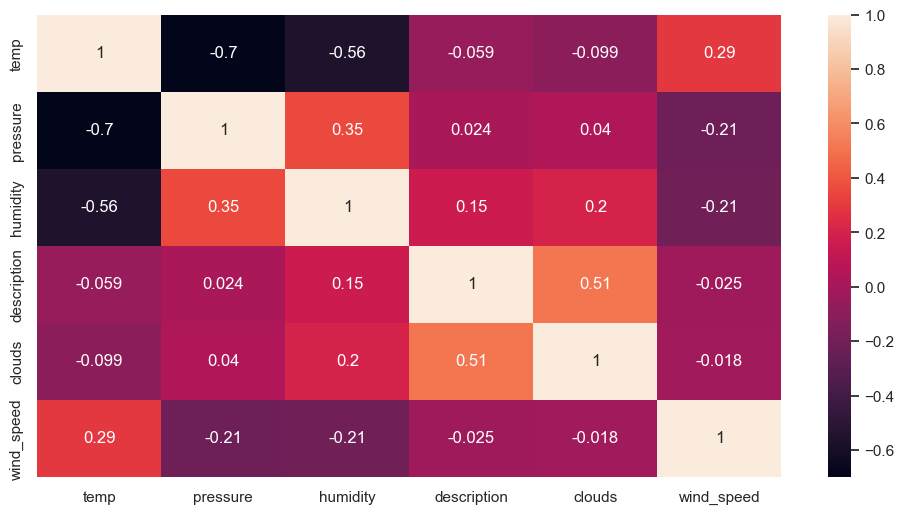

In [35]:
corrmat = df.corr()
plt.figure(figsize=(12,6))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

In [36]:
df.description.unique()

array([8, 1, 0, 2, 4, 7, 6, 5, 9, 3])

In [37]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=42)


In [38]:
#from sklearn import svm
#classifier = svm.SVC(kernel='linear')
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
#from sklearn.svm import LinearSVC
#classifier = LinearSVC()

In [39]:
classifier.fit(x_train, y_train)

RandomForestClassifier()

In [40]:
x_train_prediction = classifier.predict(x_train)
train_data_accuracy = accuracy_score(x_train_prediction, y_train)

In [41]:
print('Accuracy score of the train data:' , train_data_accuracy)

Accuracy score of the train data: 0.9989737274220033


In [42]:
x_test_prediction =classifier.predict(x_test)
test_data_accuracy= accuracy_score(x_test_prediction, y_test)

In [43]:
print('Accuracy score of the test data:' , test_data_accuracy)

Accuracy score of the test data: 0.7733990147783252


In [44]:
knn=KNeighborsClassifier()
knn.fit(x_train,y_train)
print("KNN Accuracy:{:.2f}%".format(knn.score(x_test,y_test)*100))

KNN Accuracy:75.21%


In [45]:
svm=SVC()
svm.fit(x_train,y_train)
print("SVM Accuracy:{:.2f}%".format(svm.score(x_test,y_test)*100))

SVM Accuracy:53.69%


In [46]:
gbc=GradientBoostingClassifier(subsample=0.2,n_estimators=450,max_depth=2,max_leaf_nodes=25)
gbc.fit(x_train,y_train)
print("Gradient Boosting Accuracy:{:.2f}%".format(gbc.score(x_test,y_test)*100))

Gradient Boosting Accuracy:76.68%


In [47]:
#import warnings
#warnings.filterwarnings('ignore')
xgb=XGBClassifier()
xgb.fit(x_train,y_train)
print("XGB Accuracy:{:.2f}%".format(xgb.score(x_test,y_test)*100))

XGB Accuracy:77.59%


In [58]:
input_data=[[25,1016,56,44,2.85]]
input_data_as_numpy_array = np.asarray(input_data)
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)
ot=classifier.predict(input_data_reshaped)[0]
print("The value of the ot:", ot)

print("The weather is:")
if(ot==0):
    print("Broken Clouds")
elif(ot==1):
    print("Clear Sky")
elif(ot==2):
    print("Few Clouds")
elif(ot==3):
    print("Heavy rain")
elif(ot==4):
    print("Light Rain")
elif(ot==5):
    print("Light snow")
elif(ot==6):
    print("Moderate rain")
elif(ot==7):
    print("Overcast cloud")
elif(ot==8):
    print("Scatter cloud")
elif(ot==9):
    print("Snow")
else:
    print("Sunny")

The value of the ot: 8
The weather is:
Scatter cloud


In [59]:
import pickle

In [60]:
filename = 'trained_model.sav'
pickle.dump(classifier, open(filename, 'wb') )

In [61]:
#loading the saved model
loaded_model =pickle.load(open('trained_model.sav', 'rb'))

In [62]:

input_data = [[25,1016,56,44,2.85]]
input_data_as_numpy_array = np.asarray(input_data)
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)
ot = loaded_model.predict(input_data_reshaped)[0]
print("The value of the ot:", ot)

print("The weather is:")
if ot==0:
    print("Broken Clouds")
elif ot==1:
    print("Clear Sky")
elif ot==2:
    print("Few Clouds")
elif ot==3:
    print("Heavy rain")
elif ot==4:
    print("Light Rain")
elif ot==5:
    print("Light snow")
elif ot==6:
    print("Moderate rain")
elif ot==7:
    print("Overcast cloud")
elif ot==8:
    print("Scatter cloud")
elif ot==9:
    print("Snow")
else:
    print("Sunny")



The value of the ot: 8
The weather is:
Scatter cloud
